In [1]:
#Importing some standard packages

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

In [2]:
#Specify the training set directory for our model

pathfolder1 = './dataset_updated/training_set'


#Now specify the categories we are trying to identify

categories = ['drawings', 'engraving', 'iconography', 'sculpture']

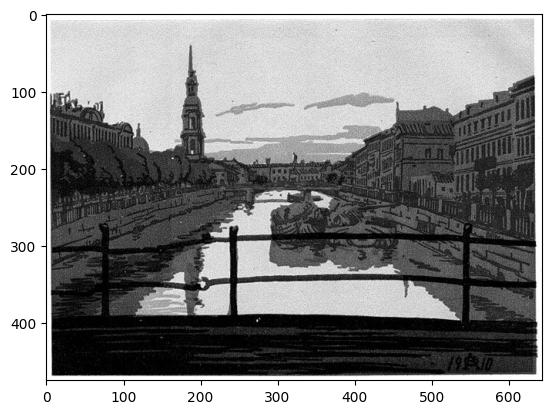

In [3]:
#We want to label each of the images that we use from each of our folders with their folder title. This gives their class.
#painting, drawing, engraving etc..

#also, load in grayscale. This simplifies working with the data. Also I don't necessarily think colour is an important differentiator.

for category in categories:
    path = os.path.join(pathfolder1, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_array, cmap='gray')
        plt.show()
        break
    break

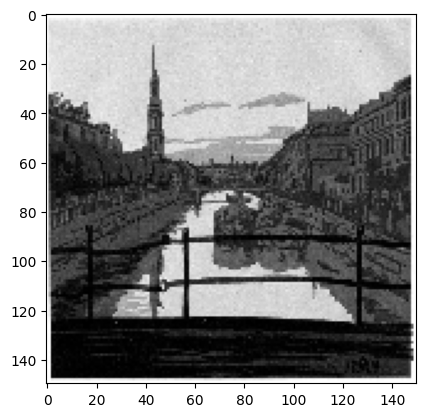

In [4]:
#we also want to rescale our images so that we have the same scale for everything.
#choose 150 for now, making it larger will probably help accuracy, but will be more computationally expensive.

img_size = 150

new_array = cv2.resize(img_array, (img_size,img_size))
plt.imshow(new_array, cmap='gray')

In [5]:
#we are going to use our snippet from above to create our training data set with a function.

training_data = []

#use for loop from above to define a function
#the try-except will pass over images that do not load correctly.

#the class_num variable adds an index to each of the images loaded according to their category

#0=drawings
#1=engravings
#etc..

def create_training_data():
    for category in categories:
        path = os.path.join(pathfolder1, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE) #read everything in grayscale
                new_array = cv2.resize(img_array, (img_size,img_size))
                training_data.append([new_array, class_num])
            except Exception as e: #if it won't load, skip it
                pass

            
create_training_data()


In [6]:
#we need to randomize the order of the data for the model to work correctly

import random

random.shuffle(training_data)

In [7]:
print(len(training_data))

5663


In [8]:
X = []
y = []

#create our feature and targets

for features, label in training_data:
    X.append(features)
    y.append(label)
    
#both need to be arrays for keras
    
X = np.array(X).reshape(-1, img_size, img_size, 1)
y = np.array(y)

#if we're running this with colour, the final number in the shape of the X array will be 3 (for RGB), here it's 1, because it's grayscale

#normalize data. can just divide by 255 for this.

X = X/255

X.shape

(5663, 150, 150, 1)

In [9]:
#Add all the necessary layers here and check our model!

#Add all the necessary layers here and check our model!

model = Sequential()
model.add(Conv2D(64, (3,3), input_shape = X.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(64))
model.add(Activation('relu'))

#Dense 5 here because our categories range from 0-4

model.add(Dense(4))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      640       
                                                                 
 activation (Activation)     (None, 148, 148, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 activation_1 (Activation)   (None, 72, 72, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                    

In [10]:
#loss=sparse_categorical_crossentropy because we have not one hot encoded our categories

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

model.fit(X, y, batch_size=40, epochs=5, validation_split=0.1)

Epoch 1/5
128/128 [==============================] - 188s 1s/step - loss: 1.0449 - accuracy: 0.5644 - val_loss: 0.8295 - val_accuracy: 0.6667
Epoch 2/5
128/128 [==============================] - 176s 1s/step - loss: 0.6753 - accuracy: 0.7451 - val_loss: 0.6302 - val_accuracy: 0.7549
Epoch 3/5
128/128 [==============================] - 158s 1s/step - loss: 0.5213 - accuracy: 0.8040 - val_loss: 0.5709 - val_accuracy: 0.7937
Epoch 4/5
128/128 [==============================] - 159s 1s/step - loss: 0.3721 - accuracy: 0.8644 - val_loss: 0.5569 - val_accuracy: 0.8113
Epoch 5/5
128/128 [==============================] - 164s 1s/step - loss: 0.2381 - accuracy: 0.9205 - val_loss: 0.6408 - val_accuracy: 0.8113


In [11]:
model.save('model.h5')

In [19]:
from PIL import Image
img = Image.open('test3.jpeg').convert('L').resize((150, 150), Image.ANTIALIAS)
img = np.array(img)
model.predict(img[None,:,:])

1/1 [==============================] - 0s 27ms/step


c:\users\hp\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  


array([[0., 0., 1., 0.]], dtype=float32)